In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date

In [2]:
pd.set_option('expand_frame_repr', False)  # 当列太多时不换行
pd.set_option('display.max_rows', 5000)  # 最多显示数据的行数

# Get a stock history data

In [3]:
# Download historical market data for GFS
# =====读入股票数据
ticker = "GFS"
# 输入开始和结束日期(if needed)
start_date = datetime(2021, 1, 1)
end_date = date.today()

# 通过yahoo finance获取所有交易数据
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.shape

(353, 6)

### Data wrangling (if needed)

In [5]:
# # 排序、去重
# df.sort_values(by=['Date'], inplace=True)
# df.drop_duplicates(subset=['Date'], inplace=True)
# df.reset_index(inplace=True, drop=True)
# # 原数据标题空格替换为"_"
df['Adj_Close'] = df['Adj Close']
df.drop(['Adj Close'], axis=1, inplace=True)
# df.set_index('Date',inplace=True)

### write data into a h5-file

In [6]:
# df.to_hdf('./data/gfs.h5', key='df', mode='w')

In [7]:
df = pd.read_hdf('./data/gfs.h5', 'df')

In [8]:
df.head(2)

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2021-10-28 00:00:00-04:00,47.009998,48.00,44.480000,46.400002,18618900,46.400002
2021-10-29 00:00:00-04:00,46.000000,49.48,45.610001,48.740002,4639400,48.740002


# 产生策略信号

In [9]:
"""
择时策略中使用到的signal函数
"""

# =====移动平均线策略
# 简单移动平均线策略
def simple_moving_average_signal(df, para=(10, 90)):
    """
    简单的移动平均线策略。只能做多。
    当短期均线上穿长期均线的时候，做多，当短期均线下穿长期均线的时候，平仓
    :param df:
    :param para: ma_short, ma_long
    :return: 最终输出的df中，新增字段：signal，记录发出的交易信号
    """

    # ===策略参数
    ma_short = para[0]  # 短期均线。ma代表：moving_average
    ma_long = para[1]  # 长期均线

    # ===计算均线。所有的指标，都要使用复权价格进行计算。
    df['ma_short'] = df['Adj_Close'].rolling(ma_short, min_periods=1).mean()
    df['ma_long'] = df['Adj_Close'].rolling(ma_long, min_periods=1).mean()

    # ===找出做多信号
    condition1 = df['ma_short'] > df['ma_long']  # 短期均线 > 长期均线
    condition2 = df['ma_short'].shift(1) <= df['ma_long'].shift(1)  # 上一周期的短期均线 <= 长期均线
    df.loc[condition1 & condition2, 'signal'] = 1  # 将产生做多信号的那根K线的signal设置为1，1代表做多

    # ===找出做多平仓信号
    condition1 = df['ma_short'] < df['ma_long']  # 短期均线 < 长期均线
    condition2 = df['ma_short'].shift(1) >= df['ma_long'].shift(1)  # 上一周期的短期均线 >= 长期均线
    df.loc[condition1 & condition2, 'signal'] = 0  # 将产生平仓信号当天的signal设置为0，0代表平仓

    # ===删除无关中间变量
#     df.drop(['ma_short', 'ma_long'], axis=1, inplace=True)

    return df


# 简单移动平均线策略参数
def simple_moving_average_para_list(ma_short=range(10, 200, 10), ma_long=range(10, 300, 10)):
    """
    产生简单移动平均线策略的参数范围
    :param ma_short:
    :param ma_long:
    :return:
    """
    para_list = []
    for short in ma_short:
        for long in ma_long:
            if short >= long:
                continue
            else:
                para_list.append([short, long])

    return para_list


def signal_gftd(df, para: list = None):
    """
    广发TD策略V2，只能做多不能做空，形成卖出形态会转换成平多仓
    :param df:  原始数据
    :param para:  参数，[n1, n2, n3]
    :return:
    """

    # 辅助函数，先跳过两个函数的内容
    def is_buy_count(i, pre_close) -> bool:
        """
        判断是否计数为买入形态，需要A，B，C三个条件同时满足才行
        :param i: 当前循环的index
        :param pre_close: 上一次计数的收盘价，第一次为None，会忽略C条件
        :return: bool
        """
        # A. 收盘价大于或等于之前第 2 根 K 线最高价;
        a = df.at[i, '收盘价_复权'] >= df.at[i - 2, '最高价_复权']
        # B. 最高价大于之前第 1 根 K 线的最高价;
        b = df.at[i, '最高价_复权'] > df.at[i - 1, '最高价_复权']
        # C. 收盘价大于之前第 1 个计数的收盘价。
        c = (df.at[i, '收盘价_复权'] > pre_close) if pre_close is not None else True
        return a and b and c

    def is_sell_count(i, pre_close) -> bool:
        """
        判断是否计数为卖出形态，需要A，B，C三个条件同时满足才行
        :param i: 当前循环的index
        :param pre_close: 上一次计数的收盘价，第一次为None，会忽略C条件
        :return: bool
        """
        # A. 收盘价小于或等于之前第 2 根 K 线最低价;
        a = df.at[i, '收盘价_复权'] <= df.at[i - 2, '最低价_复权']
        # B. 最低价小于之前第 1 根 K 线的最低价;
        b = df.at[i, '最低价_复权'] < df.at[i - 1, '最低价_复权']
        # C. 收盘价小于之前第 1 个计数的收盘价。
        c = (df.at[i, '收盘价_复权'] < pre_close) if pre_close is not None else True
        return a and b and c

    # ===参数
    if para is None:
        para = [4, 4, 4]  # 默认为4，4，4

    n1, n2, n3 = para

    # ===寻找启动点
    # 计算ud
    df['ud'] = 0  # 首先设置为0
    # 根据收盘价比较设置1或者-1
    df.loc[df['收盘价_复权'] > df.shift(n1)['收盘价_复权'], 'ud'] = 1
    df.loc[df['收盘价_复权'] < df.shift(n1)['收盘价_复权'], 'ud'] = -1

    # 对最近n2个ud进行求和
    df['udc'] = df['ud'].rolling(n2).sum()

    # 找出所有形成买入或者卖出的启动点，并且赋值为1或者-1
    # -1代表买入启动点，1代表卖出启动点
    df.loc[df['udc'].abs() == n2, 'checkpoint'] = df['udc'] / n2

    # 找出所有启动点的索引值，即checkpoint那一列非空的所有行
    check_point_index = df[df['checkpoint'].notnull()].index

    # ===生成买入或者卖出信号
    # [主循环] 从前往后，针对启动点的索引值进行循环
    for index in check_point_index:
        # 我们实际使用1代表买入，和启动点（checkpoint）正好相反，
        # 取负数就能计算得到可能使用的信号值，这里卖出信号是-1，之后会有处理
        signal = -df.at[index, 'checkpoint']

        # 缓存信号形成过程中的最高价和最低价，用于计算止损价格
        min_price = df.loc[index - n2: index, '最低价_复权'].min()
        max_price = df.loc[index - n2: index, '最高价_复权'].max()

        pre_count_close = None  # 之前第1个计数的收盘价，默认为空
        cum_count = 0  # 满足计数形态的累计值，默认清零
        stop_lose_price = 0  # 止损价格

        # [子循环] 从启动点（checkpoint）下一根k线开始往后，搜索满足buy count和sell count的形态
        for index2 in df.loc[index + 1:].index:
            close = df.at[index2, '最低价_复权']  # 当前收盘价
            min_price = min(min_price, close)  # 计算信号开始形成到这一步的最低价
            max_price = max(max_price, close)  # 计算信号开始形成到这一步的最高价

            # ==如果当前是启动点，并且当前k线满足buy count的形态
            # 1. 累计加一
            # 2. 缓存当前收盘价
            # 3. 记录止损价格（这一步并不会放到df中）
            if signal == 1 and is_buy_count(index2, pre_count_close):
                # 买入启动点
                cum_count += 1
                pre_count_close = close  # 更新前一个计数收盘价
                stop_lose_price = min_price
            elif signal == -1 and is_sell_count(index2, pre_count_close):
                # 卖出启动点
                cum_count += 1
                pre_count_close = close  # 更新前一个计数收盘价
                stop_lose_price = max_price

            # ==如果遇到新的启动点，重新开始计数
            #   退出子循环，继续主循环的下一个启动点处理
            if df.at[index2, 'checkpoint'] > 0 or df.at[index2, 'checkpoint'] < 0:
                break

            # ==如果累计计数达到n3，发出交易信号
            #   退出子循环，继续主循环的下一个启动点处理
            if cum_count == n3:
                # 设置当前信号
                df.loc[index2, 'signal'] = max(signal, 0)  # 如果是-1就赋值为0，这个信号函数不包含做空
                df.loc[index2, 'stop_lose_price'] = stop_lose_price  # 设置产生信号的时候的止损价格
                break

    # ===新增了signal（信号）列和对应的stop_lose_price（止损价）列
    # ===处理止损信号
    df['stop_lose_price'].fillna(method='ffill', inplace=True)  # 设置当前信号下所有行的止损价格
    df['cur_sig'] = df['signal']
    df['cur_sig'].fillna(method='ffill')
    stop_on_long_condition = (df['cur_sig'] == 1) & (df['收盘价_复权'] < df['stop_lose_price'])
    stop_on_short_condition = (df['cur_sig'] == 0) & (df['收盘价_复权'] > df['stop_lose_price'])
    df.loc[stop_on_long_condition | stop_on_short_condition, 'signal'] = 0  # 设置止损平仓信号

    # ===信号去重复
    temp = df[df['signal'].notnull()][['signal']]
    temp = temp[temp['signal'] != temp['signal'].shift(1)]
    df['signal'] = temp['signal']

    # ===去除不要的列
    df.drop(['ud', 'udc', 'checkpoint', 'stop_lose_price', 'cur_sig'], axis=1, inplace=True)

    # ===由signal计算出实际的每天持有仓位
    # signal的计算运用了收盘价，是每根K线收盘之后产生的信号，到第二根开盘的时候才买入，仓位才会改变。
    df['pos'] = df['signal'].shift()
    df['pos'].fillna(method='ffill', inplace=True)
    df['pos'].fillna(value=0, inplace=True)  # 将初始行数的position补全为0
    return df


### MA参数样例设置

In [10]:
MA = (80,160)

In [11]:
df_1 = simple_moving_average_signal(df,MA)

In [12]:
df_1['candle_begin_time']=df_1.index

# 绘制买卖点图表

In [13]:

def draw_signal_img(df, title = '', info = '', img_name='signal_img.jpg', save_img=False, show_img=True):
        """
        使用Matplotlib绘制买卖信号图示

        df: 包含这些字段：candle_begin_time, Open, Close, signal
        title: 标题，在图片顶部显示
        info: 说明信息，在图片右侧显示
        img_name: 图片保存的文件名
        save_img: 是否保存图片
        show_img: 是否自动显示图片
        """

        import matplotlib.gridspec as gridspec


        plt.rcParams['font.family'] = 'Hei'        # MAC用来正常显示中文标签
        plt.rcParams['font.size'] = 12                  # 设置字号
        plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号

        fig = plt.figure(tight_layout=False, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')    # 如果要调整图片大小，修改figsize (24, 16) = 1920x1280
        gs = gridspec.GridSpec(10, 10)

        # ma_long 线
        #ax = fig.add_subplot(gs[0:8, 0:8])
        ax = fig.add_subplot(gs[:, :])
        ax.plot(df.index, df['ma_long'], color='green', label='ma_long')
        ax.set_ylabel('价格')
        ax.set_xlabel('日期')
        # ma_short 线
        ax.plot(df.index, df['ma_short'], color='blue', label='ma_short')
        ax.legend(loc='upper center')
        

        signals_df = df[df['signal'].notnull()][['candle_begin_time', 'signal', 'ma_short']]
        prev_close = None
        prev_signal = 0
        prev_time = None
        for _, row in signals_df.iterrows():
            market = 'o'
            color = 'blue'
            if row['signal'] == 1:
                market = '^'
                color = 'green'
            elif row['signal'] == 0:
                market = 'v'
                color = 'red'
            ax.plot(row['candle_begin_time'], row['ma_short'], marker=market, color=color, markersize=15)
            if market == '^':
                ax.text(row['candle_begin_time'], row['ma_short'], str(row['candle_begin_time'])+'买入')
            else:
                ax.text(row['candle_begin_time'], row['ma_short'], str(row['candle_begin_time'])+'卖出')
            if prev_close is not None and prev_signal == 1:
                diff_close = (row['ma_short'] - prev_close)
                diff_pct = round(float(diff_close / prev_close) * 100.0, 2)
                if diff_close > 0:
                    ax.text(prev_time, prev_close * 1.01, f'{diff_pct}%', color='green', ha='center')
                elif diff_close < 0:
                    ax.text(prev_time, prev_close * 1.01 , f'{diff_pct}%', color='red', ha='center')
            prev_time = row['candle_begin_time']
            prev_close = row['ma_short']
            prev_signal = row['signal']
       
        # 标题和统计信息
        ax.set_title(title, fontsize='large', fontweight='bold', color='blue', loc='center')  # 设置字体大小与格式
        fig.text(0.92, 0.5, info, color='black', ha='right', va='center')

        # 保存图片
        if save_img:
            plt.savefig(img_name)

        # 显示图片
        if show_img:
            plt.show()

        if save_img or show_img:
            plt.clf()
            plt.close()



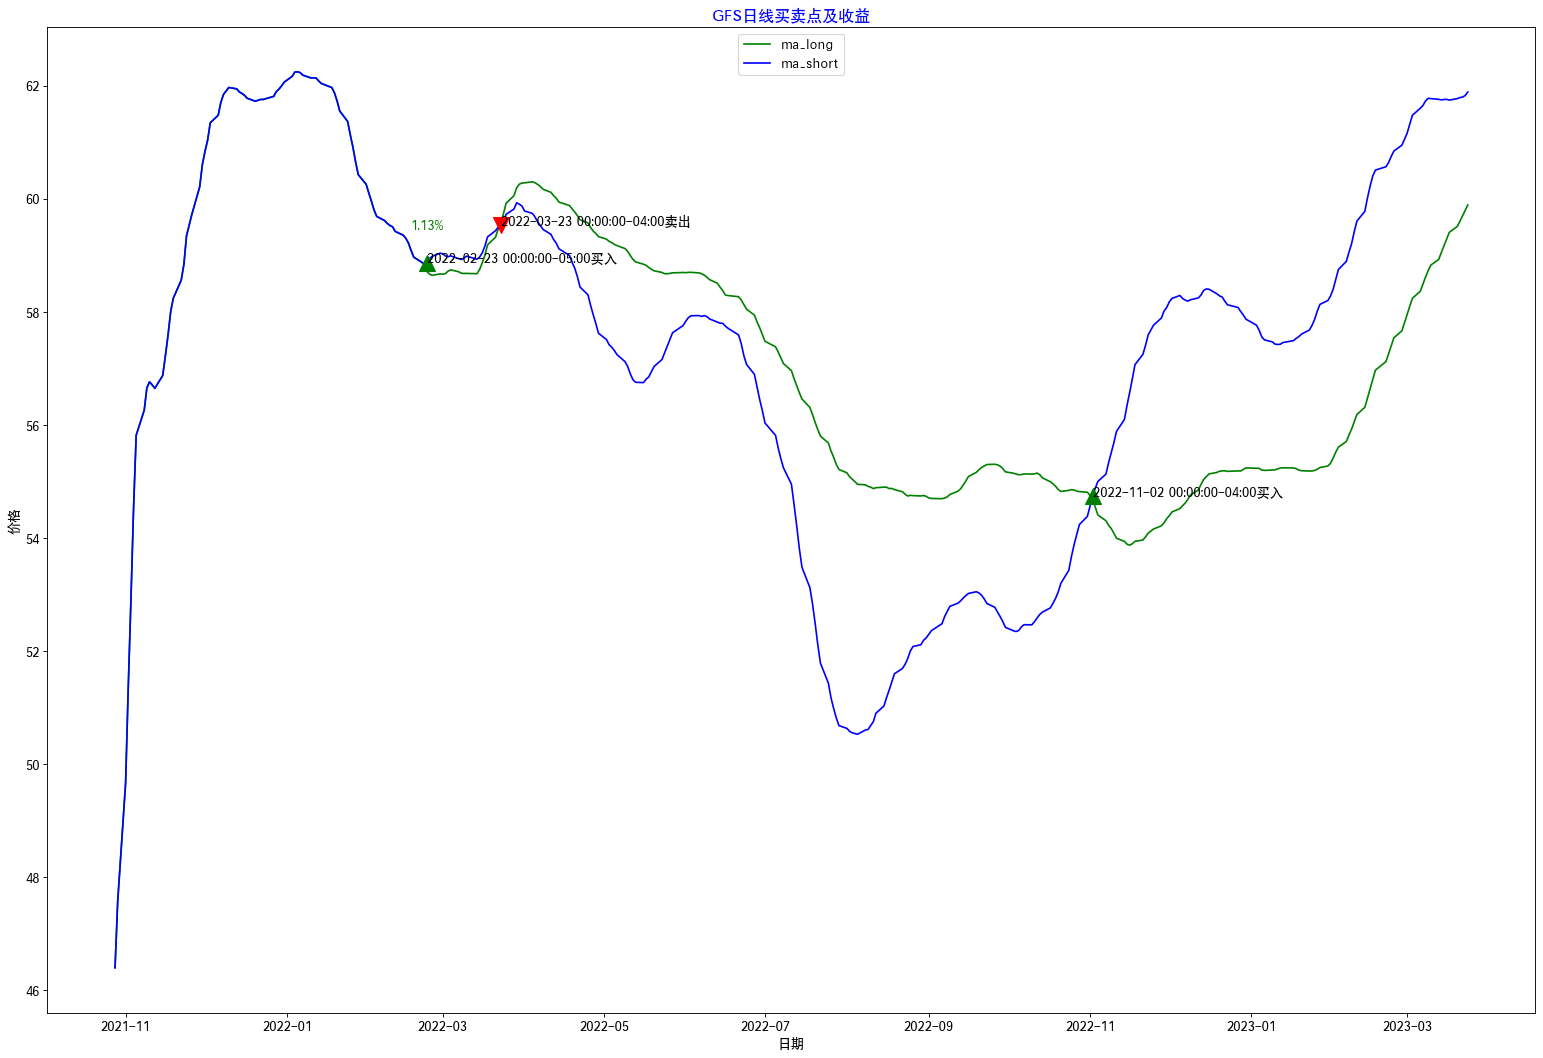

In [14]:
draw_signal_img(df_1,title="GFS日线买卖点及收益")

# 产生实际持仓

In [15]:
# 对于日线数据，会遇到涨跌停，无法买卖的股票（20%）

def cal_zhangting_price(df):
    """
    计算股票当天的涨跌停价格。在计算涨跌停价格的时候，按照严格的四舍五入。
    :param df: 必须得是日线数据。必须包含的字段：前收盘价，开盘价，最高价，最低价
    :return:
    """

    # 计算涨跌停价格
    df['涨停价'] = df['Adj_Close'].shift(1) * 1.2
    df['跌停价'] = df['Adj_Close'].shift(1) * 0.8
    df['涨停价'] = df['涨停价'].apply(lambda x: float(Decimal(x * 100).quantize(Decimal('1'), rounding=ROUND_HALF_UP) / 100))
    df['跌停价'] = df['跌停价'].apply(lambda x: float(Decimal(x * 100).quantize(Decimal('1'), rounding=ROUND_HALF_UP) / 100))

    return df


In [16]:
"""
择时策略中使用到的计算持仓的函数
"""

# 由交易信号产生实际持仓
def position_at_close(df):
    """
    根据signal产生实际持仓。考虑涨跌停不能买入卖出的情况。
    所有的交易都是发生在产生信号的K线的结束时
    :param df:
    :return:
    """
    # ===由signal计算出实际的每天持有仓位
    # 在产生signal的k线结束的时候，进行买入
    df['signal'].fillna(method='ffill', inplace=True)
    df['signal'].fillna(value=0, inplace=True)  # 将初始行数的signal补全为0
    df['pos'] = df['signal'].shift()
    df['pos'].fillna(value=0, inplace=True)  # 将初始行数的pos补全为0

    # ===对涨跌停无法买卖做出相关处理。
    # 找出收盘价无法买入的K线
    # cannot_buy_condition = df['收盘价'] >= df['涨停价']
    # # 将找出上一周期无法买入的K线、并且signal为1时，的'pos'设置为空值
    # df.loc[cannot_buy_condition.shift() & (df['signal'].shift() == 1), 'pos'] = None  
    #
    # # 找出收盘价无法卖出的K线
    # cannot_sell_condition = df['收盘价'] <= df['跌停价']
    # # 将找出上一周期无法卖出的K线、并且signal为0时的'pos'设置为空值
    # df.loc[cannot_sell_condition.shift() & (df['signal'].shift() == 0), 'pos'] = None

    # pos为空的时，不能买卖，只能和前一周期保持一致。
    df['pos'].fillna(method='ffill', inplace=True)

    # ===如果是分钟级别的数据，还需要对t+1交易制度进行处理，在之后案例中进行演示

    # ===删除无关中间变量
    df.drop(['signal'], axis=1, inplace=True)

    return df


In [17]:
df_2 = position_at_close(df_1)

In [18]:
# ===删除无关中间变量
df_2.drop(['ma_short','ma_long'], axis=1, inplace=True)
df_2.head(2)

,Open,High,Low,Close,Volume,Adj_Close,candle_begin_time,pos
Date,,,,,,,,
2021-10-28 00:00:00-04:00,47.009998,48.00,44.480000,46.400002,18618900,46.400002,2021-10-28 00:00:00-04:00,0.0
2021-10-29 00:00:00-04:00,46.000000,49.48,45.610001,48.740002,4639400,48.740002,2021-10-29 00:00:00-04:00,0.0


# 实际持仓曲线

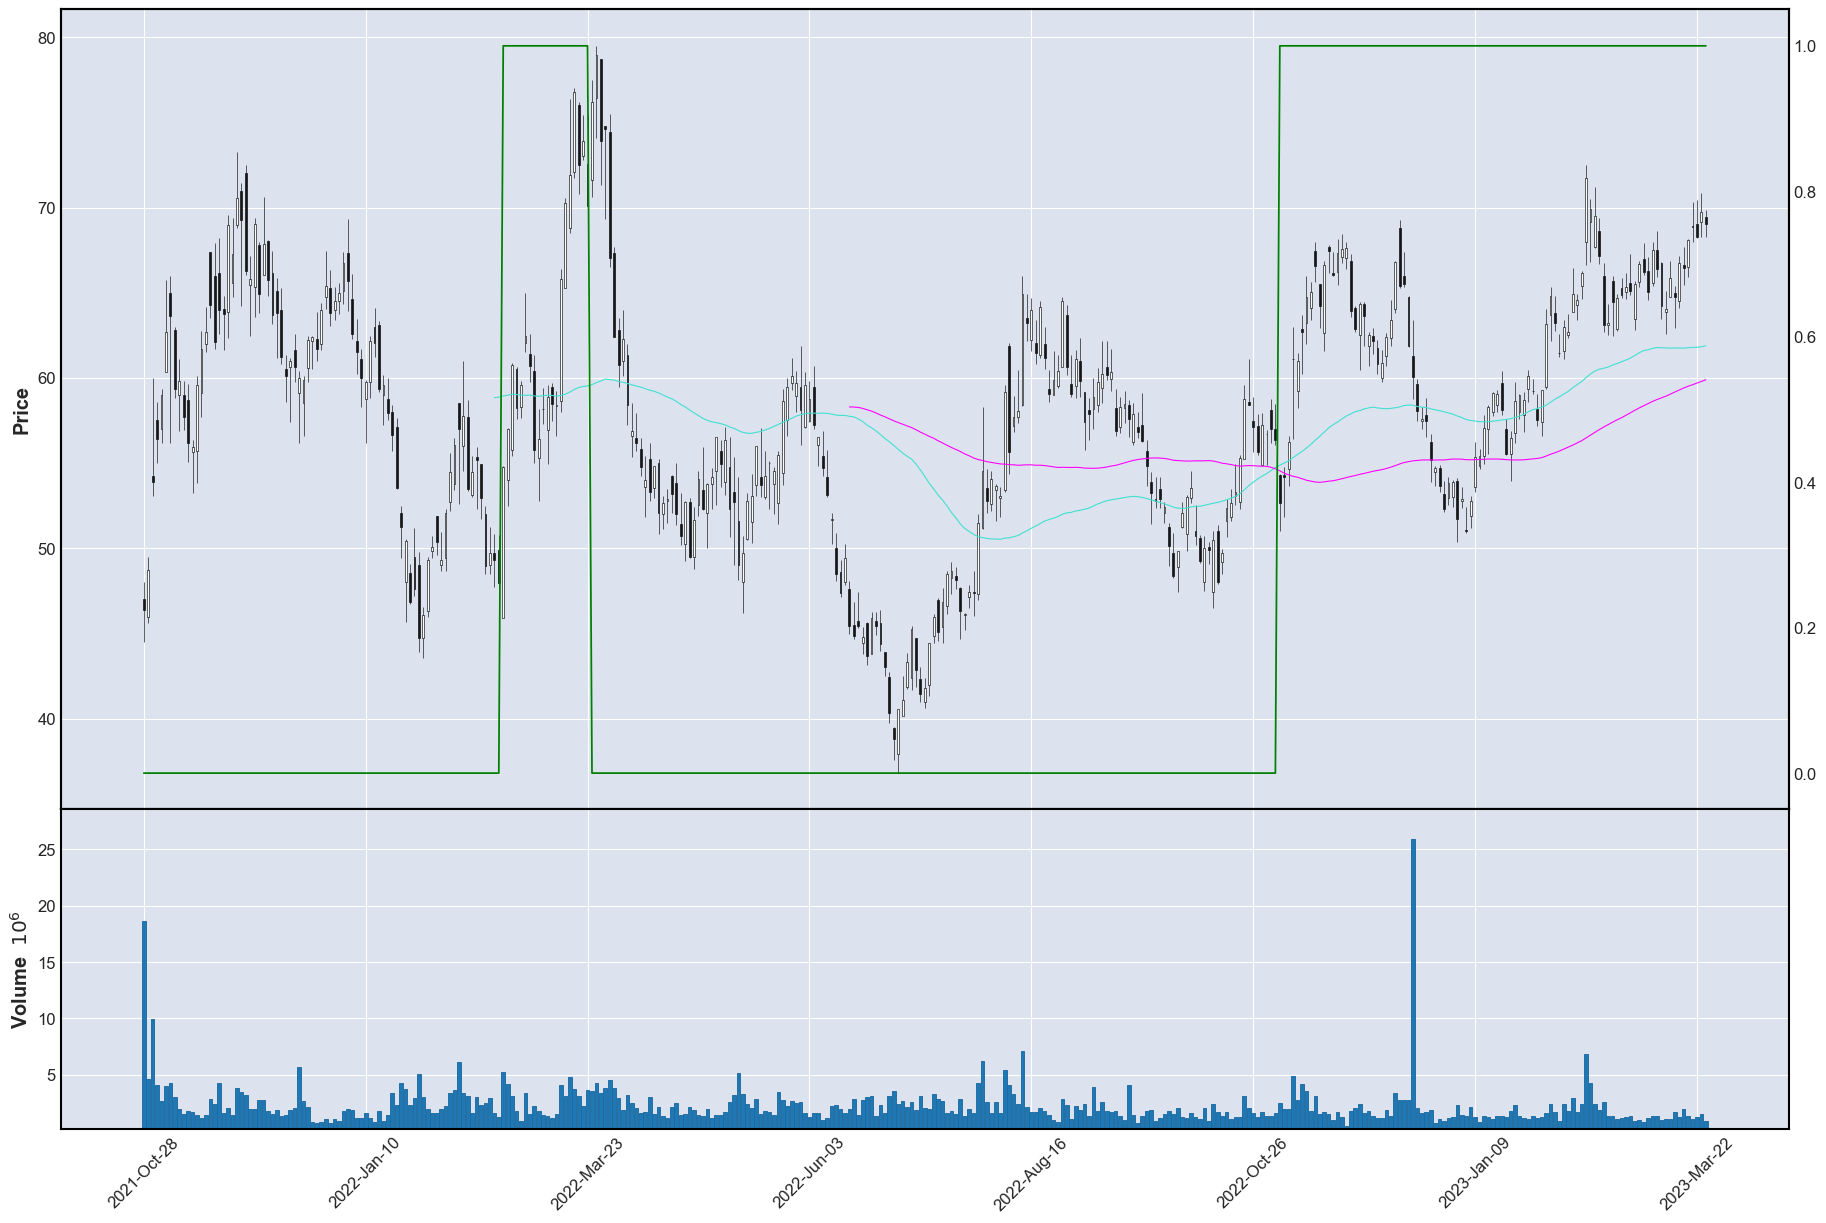

In [19]:
# create the additional plot element using make_addplot()
point_ap = mpf.make_addplot(df_2['pos'], type='line', markersize=200, marker='x', color='green')

# plot the data with the additional plot element
mpf.plot(df_1, type='candle', volume=True, addplot=[point_ap], mav=MA,figsize=(24, 16))

# display the chart
plt.show()

# 计算资金曲线

In [20]:
# =====计算资金曲线
# 股票资金曲线
def equity_curve_with_long_at_close(df, c_rate=2.5/10000, t_rate=1.0/1000, slippage=0.01):
    """
    计算股票的资金曲线。只能做多，不能做空。并且只针对满仓操作
    每次交易是以当根K线的收盘价为准。
    :param df:
    :param c_rate: 手续费，commission fees，默认为万分之2.5
    :param t_rate: 印花税，tax，默认为千分之1。etf没有
    :param slippage: 滑点，股票默认为0.01元，etf为0.001元
    :return:
    """

    # ==找出开仓、平仓条件
    # 000111100111110011100
    condition1 = df['pos'] != 0
    condition2 = df['pos'] != df['pos'].shift(1)
    open_pos_condition = condition1 & condition2

    condition1 = df['pos'] != 0
    condition2 = df['pos'] != df['pos'].shift(-1)
    close_pos_condition = condition1 & condition2

    # ==对每次交易进行分组
    df.loc[open_pos_condition, 'start_time'] = df['Date']
    df['start_time'].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, 'start_time'] = pd.NaT

    # ===基本参数
    initial_cash = 1000000  # 初始资金，默认为1000000

    # ===在买入的K线
    # 在发出信号的当根K线以收盘价买入
    df.loc[open_pos_condition, 'stock_num'] = initial_cash * (1 - c_rate) / (df['Close'] + slippage)

    # 实际买入股票数量
    df['stock_num'] = np.floor(df['stock_num'] / 100) * 100

    # 买入股票之后剩余的钱，扣除了手续费
    df['cash'] = initial_cash - df['stock_num'] * (df['Close'] + slippage) * (1 + c_rate)

    # 收盘时的股票净值
    df['stock_value'] = df['stock_num'] * df['Close']

    # ===在买入之后的K线
    # 买入之后现金不再发生变动
    df['cash'].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, ['cash']] = None

    # 股票净值随着涨跌幅波动
    group_num = len(df.groupby('start_time'))
    if group_num > 1:
        t = df.groupby('start_time').apply(lambda x: x['Adj_Close'] / x.iloc[0]['Adj_Close'] * x.iloc[0]['stock_value'])
        t = t.reset_index(level=[0])
        df['stock_value'] = t['Adj_Close']
    elif group_num == 1:
        t = df.groupby('start_time')[['Adj_Close', 'stock_value']].apply(
            lambda x: x['Adj_Close'] / x.iloc[0]['Adj_Close'] * x.iloc[0]['stock_value'])
        df['stock_value'] = t.T.iloc[:, 0]

    # ===在卖出的K线
    # 股票数量变动
    df.loc[close_pos_condition, 'stock_num'] = df['stock_value'] / df['Close']  

    # 现金变动
    df.loc[close_pos_condition, 'cash'] += df.loc[close_pos_condition, 'stock_num'] * (df['Close'] - slippage) * (
                1 - c_rate - t_rate)
    # 股票价值变动
    df.loc[close_pos_condition, 'stock_value'] = 0

    # ===账户净值
    df['net_value'] = df['stock_value'] + df['cash']

    # ===计算资金曲线
    df['equity_change'] = df['net_value'].pct_change(fill_method=None)
    df.loc[open_pos_condition, 'equity_change'] = df.loc[open_pos_condition, 'net_value'] / initial_cash - 1  # 开仓日的收益率
    df['equity_change'].fillna(value=0, inplace=True)
    df['equity_curve'] = (1 + df['equity_change']).cumprod()
    df['equity_curve_base'] = (df['Close'] / df['Close']).cumprod()

    # ===删除无关数据
    df.drop(['start_time', 'stock_num', 'cash', 'stock_value', 'net_value'], axis=1, inplace=True)

    return df


In [21]:
df_2['Date']=df_2.index
df_3 = equity_curve_with_long_at_close(df_2)

In [22]:
df_3.head(2)

,Open,High,Low,Close,Volume,Adj_Close,candle_begin_time,pos,Date,equity_change,equity_curve,equity_curve_base
Date,,,,,,,,,,,,
2021-10-28 00:00:00-04:00,47.009998,48.00,44.480000,46.400002,18618900,46.400002,2021-10-28 00:00:00-04:00,0.0,2021-10-28 00:00:00-04:00,0.0,1.0,1.0
2021-10-29 00:00:00-04:00,46.000000,49.48,45.610001,48.740002,4639400,48.740002,2021-10-29 00:00:00-04:00,0.0,2021-10-29 00:00:00-04:00,0.0,1.0,1.0


# 绘制资金曲线图表

In [23]:
"""
使用Matplotlib绘制资金曲线图

"""

EQUITY_COLUMN = 'equity_curve'  # 资金曲线值在equity_df中的列名

def draw_equity_img(equity_df, title = '', info = '', img_name='equity_img.jpg', save_img=False, show_img=True):
        """
        使用Matplotlib绘制资金曲线图

        equity_df: 资金曲线的DataFrame，必须包含这些字段：candle_begin_time, equity_curve, signal, close
        title: 标题，在图片顶部显示
        info: 说明信息，在图片右侧显示
        img_name: 图片保存的文件名
        save_img: 是否保存图片
        show_img: 是否自动显示图片
        """

        from matplotlib import pyplot as plt
        import matplotlib.gridspec as gridspec

        plt.rcParams['font.family'] = ['Hei']        # 用来正常显示中文标签
        plt.rcParams['font.size'] = 12                  # 设置字号
        plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号

        fig = plt.figure(tight_layout=False, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k')    # 如果要调整图片大小，修改figsize (24, 16) = 1920x1280
        gs = gridspec.GridSpec(10, 10)

        # 资金曲线
        ax = fig.add_subplot(gs[0:8, 0:8])
        ax.plot(equity_df['candle_begin_time'], equity_df[EQUITY_COLUMN], color='gold', label='资金曲线')
        ax.set_ylabel('净值')
        ax.set_xlabel('日期')
        ax.legend(loc='upper left')

        # 股票收盘价
        min_price = equity_df['Close'].min()
        max_price = equity_df['Close'].max()

        ax2 = ax.twinx()
        ax2.set_ylim((min_price * 0.8, max_price * 1.2))    # 设置y轴范围
        ax2.plot(equity_df['candle_begin_time'], equity_df['Close'], color='gray', alpha=0.25, label='价格')
        ax2.set_ylabel('价格')
        ax2.set_xlabel('日期')
        ax2.legend(loc='upper right')


        # 回撤
        equity_df['max2here'] = equity_df[EQUITY_COLUMN].expanding().max()
        equity_df['dd2here'] = equity_df[EQUITY_COLUMN] / equity_df['max2here'] - 1
        ax_ddraw = fig.add_subplot(gs[9:, 0:8])
        ax_ddraw.set_xlabel('日期')
        ax_ddraw.set_ylabel('回撤')
        ax_ddraw.set_ylim((0, 1))
        ax_ddraw.plot(equity_df['candle_begin_time'], -equity_df['dd2here'], color='red', alpha=0.15, label='回撤')

        # 标题和统计信息
        ax.set_title(title, fontsize='large', fontweight='bold', color='blue', loc='center')  # 设置字体大小与格式
        ax_ddraw.set_title('回撤', fontsize='medium', fontweight='bold', color='blue', loc='center')  # 设置字体大小与格式
        fig.text(0.92, 0.5, info, color='black', ha='right', va='center')

        # 保存图片
        if save_img:
            plt.savefig(img_name)

        # 显示图片
        if show_img:
            plt.show()

        if save_img or show_img:
            plt.clf()
            plt.close()



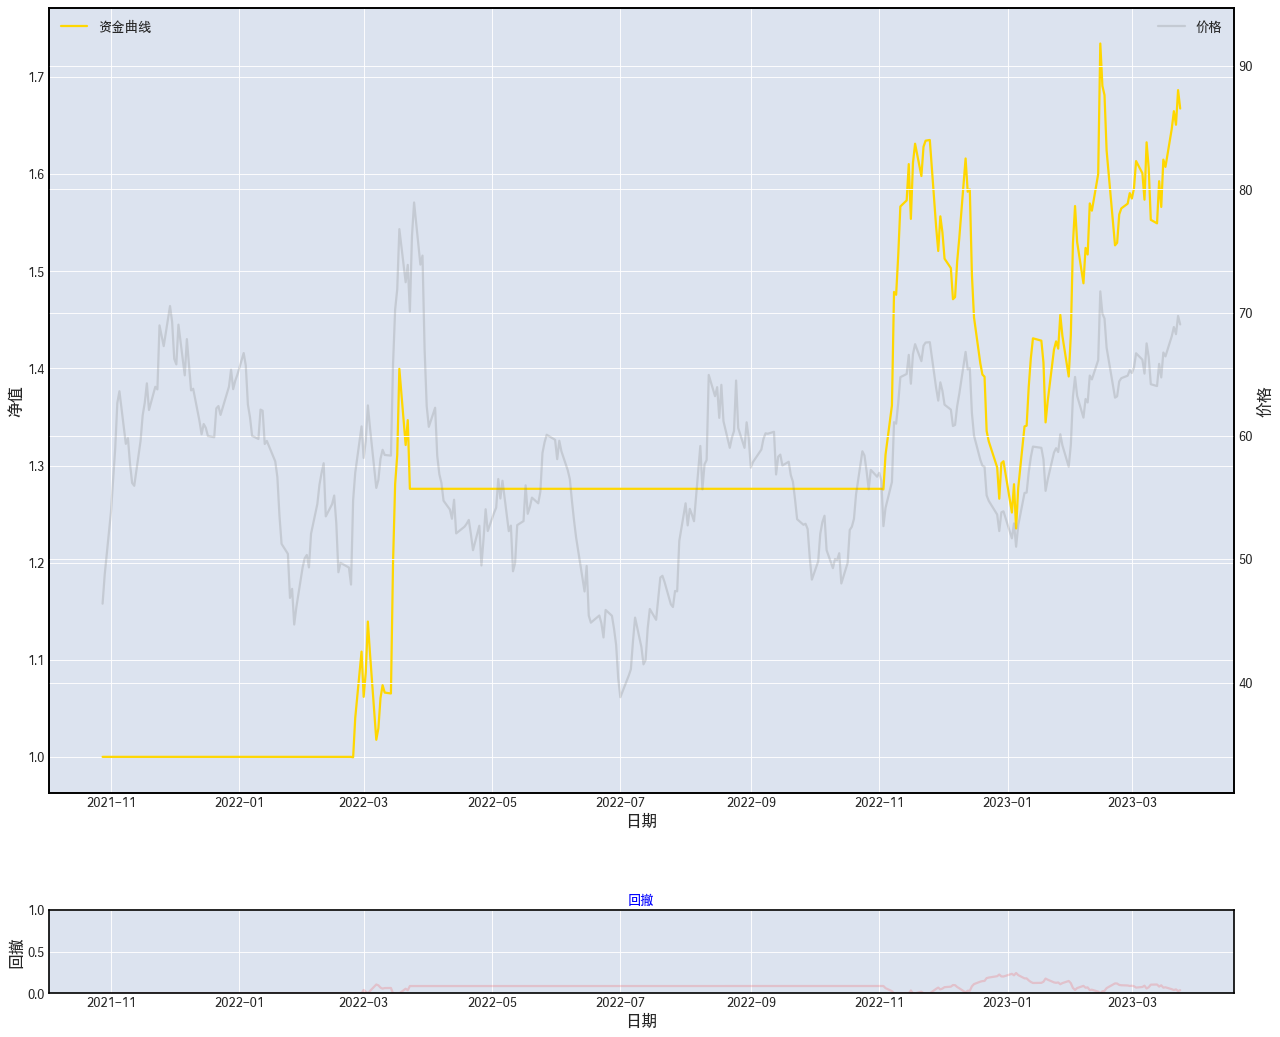

In [24]:
draw_equity_img(df_3)

# 应用实例

# 依照如上MA策略，计算最终收益

In [25]:
# =====读入股票数据
ticker = "GFS"
# 输入开始和结束日期(if needed)
start_date = datetime(2020, 1, 1)
end_date = date.today()

# 通过yahoo finance获取所有交易数据
df = yf.download(ticker, start=start_date, end=end_date)

# # 原数据标题空格替换为"_"
df['Adj_Close'] = df['Adj Close']
df.drop(['Adj Close'], axis=1, inplace=True)

# 设置Date cloumn与index一致
df['Date']=df.index

[*********************100%***********************]  1 of 1 completed


In [26]:
# 参数，这里选择双均线的参数
para = (5, 30)

# 计算交易信号
df = simple_moving_average_signal(df, para=para)

# 计算实际持仓
df = position_at_close(df)

# 计算资金曲线
df = equity_curve_with_long_at_close(df, c_rate=2.5/10000, t_rate=1.0/1000, slippage=0.01)


equity_curve = df.iloc[-1]['equity_curve']
equity_curve_base = df.iloc[-1]['equity_curve_base']
print(para, '策略最终收益：', equity_curve)


(5, 30) 策略最终收益： 0.975661002671599


# 构建迭代方法，找出最优组合

In [27]:
# 构建策略参数遍历范围
para_list = simple_moving_average_para_list(ma_short=range(10, 200, 10), ma_long=range(10, 200, 10))


# 遍历参数
rtn = pd.DataFrame()
for para in para_list:
    # 计算策略交易信号，此处df需要copy
    temp_df = simple_moving_average_signal(df.copy(), para=para)
    temp_df['Date'] = temp_df.index

    # 计算实际持仓
    temp_df = position_at_close(temp_df)

    # 选择时间段
    # 截取上市一年之后的数据
#     temp_df = temp_df.iloc[250 - 1:]  # 股市一年交易日大约250天
    # 截取2007年之后的数据
    temp_df = temp_df.loc['2020-01-01':]  # 从2020年开始

    # 计算资金曲线
    temp_df = equity_curve_with_long_at_close(temp_df, c_rate=2.5/10000, t_rate=1.0/1000, slippage=0.01)

    # 计算收益
    equity_curve = temp_df.iloc[-1]['equity_curve']
    equity_curve_base = temp_df.iloc[-1]['equity_curve_base']
#     print(para, '策略最终收益：', equity_curve)

    rtn.loc[str(para), 'equity_curve'] = equity_curve
    rtn.loc[str(para), 'equity_curve_base'] = equity_curve_base

print(rtn.sort_values(by='equity_curve', ascending=False))


            equity_curve  equity_curve_base
[180, 190]      1.866301                1.0
[120, 140]      1.845548                1.0
[80, 160]       1.667755                1.0
[80, 180]       1.562006                1.0
[80, 190]       1.562006                1.0
[80, 170]       1.562006                1.0
[120, 130]      1.537931                1.0
[80, 150]       1.535395                1.0
[60, 150]       1.526869                1.0
[80, 140]       1.496669                1.0
[60, 160]       1.468432                1.0
[60, 70]        1.466342                1.0
[170, 190]      1.448894                1.0
[80, 130]       1.433405                1.0
[110, 130]      1.418815                1.0
[60, 180]       1.406268                1.0
[70, 140]       1.401560                1.0
[60, 190]       1.392552                1.0
[60, 170]       1.392552                1.0
[110, 140]      1.364694                1.0
[130, 140]      1.347809                1.0
[160, 190]      1.343501        